In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

# 1. Table of contents:
* [What is Logistic Regression](#2)
    * [Overview of the algorithm](#2.1)
    * [A word on the Activation functions](#2.2)
* [Implementation: Binary Logistic Regression](#3)
    * [Understanding the model ](#3.1)
    * [Data Preparation](#3.2)
    * [Code](#3.3)
* [Implementation: Multiclass Logistic Regression](#4)
    * [Categorical cross entropy ](#4.1)
    * [Softmax and its derivative](#4.2)
    * [Data Preparation](#4.3)
    * [Code](#4.4)
* [More Questions](#5)

# 2. Q & A:
* [What makes the sigmoid a good choice for modeling probabilities?](#q1)
* [Why do we use softmax function for multiclass classification? ](#q1)
* [What is the origin of the BCE loss function?](#q3)
* [Why don't we use base 2 in log in the cross entropy loss function?](#q4)
* [Why is initialization of weights important?](#q5)
* [What happens if weights are not initialized properly?](#q5.1)
* [What happens if keeping everything same, we change the weight initialization?](#q5.2)
* [What is the effect on regularization on test and training accuracy?](#q6)
* [What are the limitations of the CCE function?](#q7)
* [What are the limitations of softmax function?](#q8)
* [What are some limitations of logistic regression?](#q9)
* [What are some assumptions we make when we use Logistic regression?](#q10)

# 3. What is Logistic regression? <a class="anchor" id="2"></a>

Logistic regression is a statistical modeling technique used to analyze the relationship between a dependent variable and one or more independent variables, where the dependent variable represents a binary outcome or a categorical outcome with multiple classes. 

## 3.1 Overview of the algorithm <a class="anchor" id="2.1"></a>

* *Data processing:* <br>
    Since the logistic regression is sensitive to the scales of the features of the input data, we need to normalize the data. If we don't normalize the data, some input variables with higher scales will end up having uneven influence on the model.
* *Removing outliers* <br>
    Unlike decision trees, logistic regression is sensitive to outliers. Thus, it is important to visualize the data and remove the outliers.
* *Linear combination of independent variables:* <br>
    Logistic regression creates a linear combination of input variables by multiplying them to the coefficients of the weights. The results are then summed up.
* *Sigmoid function:* <br>
    The linear combination output is then non-linearly mapped to a value between $[0,1]$ representing the estimated probability of the outcome.
* *Gradient Descent or Maximum Likelihood Estimation:* <br>
    The coefficients for the independent variables which we called weights are estimated using **Gradient Descent** or **Maximum likelihood estimation**. We want to find the parameters which maximize the probability of occurence of the data given its predictions.
* *Evaluation:* <br>
    The model can be evaluaed using several metrics such as acuracy or precision & recall.

## 3.2. A word on the Activation functions <a class="anchor" id="2.2"></a>

### **Logistic function:** 

$$ f(x)= {L \over (1+e^{-k(x−x0)}) }$$ 

In a logistic fundtion : <br>
 * $L$ controls the max value the function can take
 * $k$ controls the steepness of the curve
 * $x_0$ controls where the function is centered on the x axis

### **Sigmoid function:**

$$ S(x) = { 1 \over (1 + e^{-x}) }$$

Sigmoid function is a special case of logistic function where, 
 * max value the function can take is $1$
 * $x_0 = 0$ i.e. the function is centered at 0
 * The steepnes of the curve is $1$

The Sigmoid function takes an unbounded real value and maps it to a real value between 0 and 1. <br>

**Q: But what makes it a good choice for modeling probabilities? <br>**
 * We can map the linear combination of input variables to a value to $[0, 1]$.
 * It is a continous function.
 * It is non linear
 * It is monotonously increasing.
 * It is a differentiable function.
 
**Q: What are some limitations of the sigmoid function?**
 * It gives rise to vanishing gradients: when the x values are large in magnitude (towards the extremeties), it tends to produce a very small change in the Y value. Hence, the gradients produced are near 0.

### **Softmax function:** <a class="anchor" id="q1"></a>

$$ Softmax(x) = {e^{-x} \over {\sum_{i=0}^N e^{-x}}} $$

### **Q: Why do we use softmax function for multiclass classification?** <a class="anchor" id="q2"></a>

 * The Sigmoid function can map a value to [0, 1] and gives probability of one variable. The softmax function provides a probability distribution over all classes that sums to 1. 
 * Sigmoid models each class independently. Softmax can handle modeling dependencies between multiple classes. 
 * If we use Sigmoid for Multi class, the output probs will not sum to 1 as each class is modeled independently.
 * Numerical stability: Softmax helps avoid numerical underflow issues when there are many classes. Sigmoid is stable for binary case.

---

# 4. Implementation: Binary Logistic Regression <a class="anchor" id="3"></a>


## 4.1. Understanding the model <a class="anchor" id="3.1"></a>


 * Let's have a look at the **forward pass**: <br>
 
   Let $X$ be our input data consistting of $N$ samples, $W$ be our weights and $b$ be the bias, and $Y_T$ be the ground truth. <br>
   
   All the sample points are normalized in the `_normalize_data` function <br>
   
   $$ H = W.X + b $$ <br>
   
   Pass it through the non linear Sigmoid Activation
   
   $$ Y_{pred} = Sigmoid(H) $$  <br>
   
```python
# If X is our input data with shape (N, num_feats)

X = np.random.randn(100, 5)
weights = np.random.rand(X.shape[0])
bias = 0

def _forward_pass(X):
    H = np.dot(X, weights) + bias
    # Clip predicted probabilities to prevent overflow
    ypred = np.clip(self._sigmoid(H), self.eps, 1 - self.eps)
    return ypred
  ```
   
 * **Backward pass**: We use gradient descent here to optimize: <br>
 
   We compute Binary Cross Entropy Loss as,
   
   $$ BCE_{loss} = L = -{\sum_{i=1}^N( Y_T{log}(Y_pred) + (1 - Y_T) log (1 - Y_pred) ) \over N }$$ <br>
   So, now when we compute the gradient wrt loss, we get, 
   $$ {{\partial L} \over {\partial Y_{pred}}}  = { {-1\over N}[ {Y_T \over Y_pred} - {(1-Y_T) \over (1-Y_pred)} ] }$$
   Partial gradient of predictions over sigmoid output<br>
   (check stack overflow or derive yourself, its easy takes a few equation manipulations)
   $$ {\partial Y_{pred} \over \partial H}  = H * (1 - H)$$ <br>
   Partial gradient of $H$ over weights $W$
   $$ {\partial H \over \partial W} = X $$
   Partial gradient of $H$ over bias $b$
   $$ {\partial H \over \partial b} = 1 $$
   
   Now, using **chain-rule** of derivatives, we can stitch to find the gradient of loss $L$ wrt weights $W$ and bias $W$,
   
   $$ {\partial H \over \partial W} = {\partial L \over \partial Y_{pred}} * {\partial Y_{pred} \over \partial H}* {\partial H \over \partial W} $$
   
   Similary for bias $b$, 

   $$ {\partial H \over \partial b} = {\partial L \over \partial Y_{pred}} * {\partial Y_{pred} \over \partial H} * {\partial H \over \partial b} $$
 * Note that in this code, we use **Xavier initialization** for initialize our weights. We can also use normal initialization for this. You can run it with either and see the effect on the process. Random initialization converges slower and yields less accuracy as compared to Xavier initialization. <br>
 Checkout the function: `xavier_init`
 *  Checkout the functions `_forward_pass` and `_update_weights` on how these equations are used

### **Q: What is the origin of the BCE loss function?** <a class="anchor" id="q3"></a>

The Binary Cross Entropy (BCE) loss function originates from information theory and is commonly used in binary classification problems. It measures the dissimilarity between the predicted probabilities and the true binary labels. <br>
The concept of entropy is also derived from Information theory, where we say that how many bits it takes to store an information. If the information is distributed, then entropy is high, i.e. randomness is high.

### **Q: Then why don't we use base 2 in log in the loss function?** <a class="anchor" id="q4"></a>

In the derivatives, it doesn't make a difference, because the factor of log 2 will just be an extra constant multiplied. So, to simplify, we use base $e$.

## 4.2 Data preparation <a class="anchor" id="3.2"></a>

THe data we are using is breast cancer data from scikit learn. 
It provides featues for a region adn categorizes it as *Benign* or *Malignant*

In [88]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# load breast cancer dataset
data = load_breast_cancer()

# split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=42)


## 4.3 Code <a class="anchor" id="3.3"></a>

In [117]:
class BinaryLogisticRegression:
    
    def __init__(self, lr=1e-4, niter=5000, lambda_reg=0.0):
        self.lr = lr
        self.niter = niter
        self.lambda_reg = lambda_reg
        self.num_features = None
        self.weights = None
        self.bias = 0
        self.eps = 1e-6
        self.loss_history = None
        
    def fit(self, X, Y, init_wt='xavier', verbose=False):
        self.nsamples, self.nfeatures = X.shape
        if init_wt == 'random':
            self.weights = np.random.rand(self.nfeatures)
        elif init_wt == 'xavier':
            self.weights = self.xavier_init(X.shape, (self.nfeatures, 1))
        else:
            raise ValueError("Invalid initialization given for weights")

        self.weights = self.weights.flatten()
        self.bias = 0
        self.loss_history = []
        X = self._normalize_data(X)
        for i in range(self.niter):
            ypred = self.forward_pass(X)
            loss = self._bceloss(ypred, Y)
            self.loss_history.append(loss)
            if verbose:
                if i % 500 == 0:   
                    print(f"iter: {i+1} --> Loss: {loss}")
            self._update_weights(X, Y, ypred)
        return self.loss_history
       
    
    def predict(self, Xtest, Ytest):
        Xtest = self._normalize_data(Xtest)
        Ypred = self.forward_pass(Xtest)
        th = 0.5
        prP = Ypred > th 
        prN = Ypred <= th
        gtP = Ytest == 1
        gtN = Ytest == 0
        tp = np.sum(prP & gtP)
        tn = np.sum(prN & gtN)
        fp = np.sum(prP & gtN)
        fn = np.sum(prN & gtP)
        precision = tp/(tp + fp)
        recall = tp/(tp + fn)
        accuracy = tp/len(Xtest)
        print(f"Precision = {np.round(precision, 2)}")
        print(f"recall = {np.round(recall, 2)}")
        return Ypred
    
    def forward_pass(self, X):
        H = np.dot(X, self.weights) + self.bias
        # Clip predicted probabilities to prevent overflow
        ypred = np.clip(self._sigmoid(H), self.eps, 1 - self.eps)
        return ypred

    
    def _bceloss(self, ypred, ytrue):
        """
        BInary cross entropy loss
        """
        assert len(ypred) == len(ytrue) and len(ypred) > 0
        nsamples = len(ypred)
        loss = (-1./nsamples) * np.sum( (ytrue)* np.log(ypred + self.eps) + (1. - ytrue) * np.log(1 - ypred + self.eps) )
        reg = (self.lambda_reg/2) * np.sum(self.weights ** 2)   # L2-norm
        return loss + reg
        
    
    def _update_weights(self, X, Yt, Yp):
        # dLoss/dy = -1/N[ Yt/Yp - (1-Yt)/(1-Yp) ]
        # dY/dH = H*(1-H)
        # dH/dW = X
        # dH/dB = 1
        nsamples = len(X)
        dLoss_dy = (-1./nsamples) * np.sum( Yt/(Yp + self.eps) - (1 - Yt)/(1 - Yp + self.eps) )
        dy_dH = Yp * (1 - Yp)
        dH_dW = X
        dW = np.dot(dLoss_dy * dy_dH, dH_dW) + self.lambda_reg * self.weights # mine
        dB = np.mean(dLoss_dy * dy_dH * 1.)
        self.weights = self.weights - self.lr * dW
        self.bias = self.bias - self.lr * dB
    
    def _sigmoid(self, X):
        X = np.clip(X, -5, 5) # we clip the input to avoid unstabilities
        return 1. / (1. + np.exp(-X))
    
    def xavier_init(self, input_shape, output_shape):
        """
        Xavier initialization for weights in a linear layer
        :param input_shape: tuple, shape of input to layer
        :param output_shape: tuple, shape of output from layer
        :return: ndarray, initialized weights for layer
        """
        scale = np.sqrt(2 / (input_shape[0] + output_shape[0]))
        return np.random.randn(input_shape[1], output_shape[1]) * scale
    
    def _normalize_data(self, X):
        """
        Normalizes the data by subtracing the mean and dividing by std.
        Note that this doesn't fix the range between -1 to 1. 
        X: data with shape: (num_samples, num_feats)
        """
        mu = np.mean(X, axis=0, keepdims=True)
        std = np.std(X, axis=0, keepdims=True)
        Xnew = (X - mu) / (std + self.eps)
        return Xnew
        

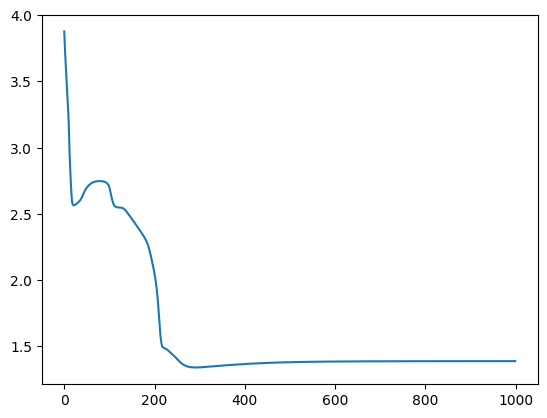

In [118]:
blr = BinaryLogisticRegression(lr=1e-3, niter=1000, lambda_reg=0.)
loss = blr.fit(X_train, Y_train, init_wt='random')

plt.plot(loss)


In [119]:
Ypred = blr.predict(X_test, Y_test)

Precision = 0.74
recall = 0.72


### **Q: Why is initialization of weights important?**  <a class="anchor" id="q5"></a>

Initialization of the weights or coefficients is crucial as it sets the starting values for the optimization algorithm used to estimate the model parameters. Proper initialization helps ensure the convergence of the optimization process and the stability of the estimated coefficients. 

**What happens if weights are not initialized properly?** <a class="anchor" id="q5.1"></a>

1. *Slow /Poor convergence:* <br>
   Poor initialization may lead to slow convergence or the algorithm getting stuck in local optima. 
2. *Degeneracy*: <br>
    If the model fails to converge, we may get unreliable results. This is called degeneracy. This can happen especially especially when the input features of the data are highly correlated.
4. *Stability issues:* <br>
   Well-initialized weights ensure that the optimization algorithm explores a reasonable parameter space, avoiding extreme or unrealistic estimates.If the weights are not initialized properly, model may explore the regions which have poor interpretability and may yield non-sensical results.
4. *Influence on regularization:* <br>
   If the weights are not initialized, then an $L1$ or $L2$ which depends on the weights can cause undesirable effects on the weights update.


**What happens if keeping everything same, we change the weight initialization?** <a class="anchor" id="q5.2"></a>

 * As you will see below when we move to xavier initialization, the loss function is much more smoother than the random initialization 

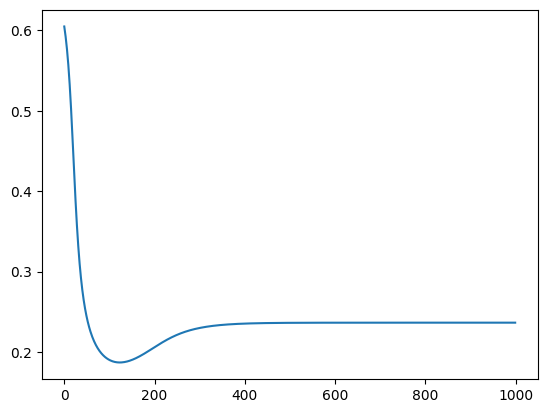

In [120]:
blr = BinaryLogisticRegression(lr=1e-3, niter=1000, lambda_reg=0.)
loss = blr.fit(X_train, Y_train, init_wt='xavier')

plt.plot(loss)

In [121]:
Ypred = blr.predict(X_test, Y_test)

Precision = 0.95
recall = 0.97


### **Q: What is the effect on regularization on test and training accuracy?** <a class="anchor" id="q6"></a>

As we increase the regularizaiton, the training metrics reduce, yet the test metrics should improve because the model is not overfitting. 

Let's see what effect does it have on our model?

In [129]:
regs = np.arange(0, 1, 0.1)

for reg in regs:
    blr = BinaryLogisticRegression(lr=1e-3, niter=5000, lambda_reg=reg)
    loss = blr.fit(X_train, Y_train, init_wt='xavier')
    print(f"\nRegulariaztion: {np.round(reg, 2)} ----------------")
    print("Train metrics")
    Ypred = blr.predict(X_train, Y_train)
    print("Test metrics")
    Ypred = blr.predict(X_test, Y_test)
    



Regulariaztion: 0.0 ----------------
Train metrics
Precision = 0.89
recall = 0.96
Test metrics
Precision = 0.95
recall = 0.97

Regulariaztion: 0.1 ----------------
Train metrics
Precision = 0.88
recall = 0.96
Test metrics
Precision = 0.95
recall = 0.97

Regulariaztion: 0.2 ----------------
Train metrics
Precision = 0.88
recall = 0.96
Test metrics
Precision = 0.95
recall = 0.97

Regulariaztion: 0.3 ----------------
Train metrics
Precision = 0.63
recall = 0.72
Test metrics
Precision = 0.74
recall = 0.77

Regulariaztion: 0.4 ----------------
Train metrics
Precision = 0.88
recall = 0.96
Test metrics
Precision = 0.95
recall = 0.97

Regulariaztion: 0.5 ----------------
Train metrics
Precision = 0.88
recall = 0.96
Test metrics
Precision = 0.95
recall = 0.97

Regulariaztion: 0.6 ----------------
Train metrics
Precision = 0.65
recall = 0.75
Test metrics
Precision = 0.79
recall = 0.79

Regulariaztion: 0.7 ----------------
Train metrics
Precision = 0.88
recall = 0.96
Test metrics
Precision = 0.9

Here are some observations from our experiment: <br>

* There is now a more evident dip in training performance at lambda values of 0.3 and 0.6, indicating the model is regularizing more.
* The corresponding test metrics also decrease at those lambda values, suggesting the regularization is helpful for generalization.
* Beyond 0.6 regularization, there is no clear improvement (or decline) in test metrics.
* Best test metrics occur in the range of lambda 0.1 to 0.4 approximately.

So in summary, some moderate regularization is beneficial for this model, with a "sweet spot" seems to be around 0.1 to 0.4 based on the validation set performance.

---
***

# 5. Implementation: Multiclass Logistic Regression <a class="anchor" id="4"></a>

Multiclass Logistic regression is more involved than the Binary logistic regression. <br>
That's the reason, I found no implementation from scratch which applied and demonstrated chain rule. <br>
But nothing to worry, I have implemented it from scratch using chain rule of differentiation to update weights.

## 5.1. Categorical cross Entropy function <a class="anchor" id="4.1"></a>

This is a generalized form of Binary cross Entropy function. It is known by multiple names:
* MultiClass Cross Entropy function
* Categorical Cross Entropy function
* Log Loss

$$
CE(y_{true}, y_{pred}) = -∑(y_{true} * log(y_{pred}))
$$

where $y_{true}$ is a **one-hot-encoded** vector.

A very easy way to encode any 1D vector into a one-hot vector is:

```python
def encode_one_hot(y_true, nclasses):
    yt_onehot = np.eye(nclasses)[y_true]
    return yt_onehot
```

**Derivative**:
$$
\frac{{\partial L}}{{\partial y_i}} = \frac{{\partial}}{{\partial y_i}} \left( -\sum_{j} yt_j \log(y_j) \right)
$$

$$
\frac{{\partial}}{{\partial y_i}} \left( -\sum_{j} yt_j \log(y_j) \right) = -\frac{{yt_i}}{{y_i}}
$$

### **Q: What are the limitations of the CCE function?** <a class="anchor" id="q7"></a>

* Non-convex: <br>
It is a non-convex function just like BCE. Makes the optimization harder. Optimization can get stuck in local minimas.
* Non-robustness to outliers: <br>
The categorical cross-entropy loss treats all misclassifications equally, without considering the degree of error. It can be sensitive to outliers or mislabeled examples, potentially leading to suboptimal solutions.
* Imbalanced data: <br>
We need to weigh the classes differently for an effective learning on imbalanced data or use other loss functions like focal loss.


## 5.2. Softmax and its derivative <a class="anchor" id="4.2"></a>


Let's understand  what a softmax function does: <br>

It takes a vector of real-valued numbers as input and transforms them into a probability distribution over multiple classes. The output of the softmax function is a vector of probabilities, where each element represents the likelihood of the corresponding class. In another words, it computes the exponential of each element in the input vector and divides it by the sum of the exponentials of all elements in the vector. This normalization ensures that the resulting probabilities sum up to 1.
$$
softmax_i = \frac{e^{a_i}}{\sum_j e^{a_j}}
$$


Derivative of softmax is complicated. 

Since, in the denominator we sum all the inputs, we will need to use the **quotient rule** for differentiation.  <br>
Also, note that when we take derivative of a softmax output wrt a softmax input, we have two cases, when the input and output indices match, and when they don't.

A much more detailed explanation is provided in this [Youtube Video](https://www.youtube.com/watch?v=5-rVLSc2XdE)

**case 1** where: *softmax output index **=** softmax input index*

$$
\frac{\partial y_i}{\partial a_i} = \frac{e^{a_i} \sum_j e^{a_j} - e^{a_i}e^{a_i}}{(\sum_j e^{a_j})^2} = \frac{e^{a_i}}{\sum_j e^{a_j}} \frac{\sum_j e^{a_j} - e^{a_i}}{\sum_j e^{a_j}} = y_i(1-y_i) = y_i - y_i y_i
\
$$

**case 2** where: *softmax output index **$\neq$** softmax input index*
$$
\frac{\partial y_i}{\partial a_k} = \frac{- e^{a_i}e^{a_k}}{(\sum_j e^{a_j})^2} = -\frac{e^{a_i}}{\sum_j e^{a_j}}\frac{e^{a_k}}{\sum_j e^{a_j}} = -y_i y_k
$$
We can think of them as two different matrices: One with all the values in ther diagonal and other as outer product $(V.V^T)$

**Matrix 1**:
\begin{bmatrix}
  y_1 & 0 & 0 & \cdots & 0 \\
  0 & y_2 & 0 & \cdots & 0 \\
  \vdots & \vdots & \vdots & \ddots & \vdots \\
  0 & 0 & 0 & \cdots & y_n
\end{bmatrix}


**Matrix 2**:
\begin{bmatrix}
  y_1 y_1 & y_1 y_2 & y_1 y_3 & \cdots & y_1 y_n \\
  y_2 y_1 & y_2 y_2 & y_2 y_3 & \cdots & y_2 y_n \\
  \vdots & \vdots & \vdots & \ddots & \vdots \\
  y_n y_1 & y_n y_2 & y_n y_3 & \cdots & y_n y_n
\end{bmatrix}

Thus, our derivative of softmax is the difference of these two: $M1 - M2$. 

In code, this is how it will look like

```python
def _softmax(logits):
    """
    Softmax function (different from sigmoid)
    logits: un-normalized scores Nsamples, Nclasses
    """
    logits = np.clip(logits, -10, 10) # we clip the input to avoid unstabilities
    exp_logits = np.exp(logits - logits.max(axis=0, keepdims=True))
    return exp_logits / (np.sum(exp_logits, axis=1, keepdims=True) + self.eps)


def _softmax_derivative(self, softmax_output):
    """
    Computes derivative of a softmax function.
    Note that softmax derivative is different where numerator and denominator match and where they don't
    """
    nclasses = softmax_output.shape[1]
    # M1 in the description 
    M1 = softmax_output[:, :, np.newaxis] * np.eye(nclasses)
    # M2 in the description
    M2 = softmax_output[:, np.newaxis, :] * softmax_output[:, :, np.newaxis]
    derivative = M1 - M2
    return derivative
```

### **Q: What are the limitations of softmax function?** <a class="anchor" id="q8"></a>

* Outlier sensitivity: <br>
The softmax function is sensitive to outliers or extreme values in the input vector. If the input values are very large or very small, the exponentiation step in the softmax function can lead to numerical instability or overflow. Hence, in the code below, I use clipping to clip the values of the logits. See `_softmax` above.
* Class dependence: <br>
The probabilities are not independent due to the normalization. Changing one class affects others.
* Vanishing gradients: <br>
With peaky probabilities near 0 or 1, gradients of softmax can vanish.


## 5.3. Data Preparation <a class="anchor" id="4.3"></a>


We will run this on the **Iris dataset**.

In [126]:
rootpath = "../../"

In [127]:
csvpath = os.path.join(rootpath, "assets/iris.csv")
df = pd.read_csv(csvpath)
num_samples, num_feats = df.shape
print(f"Total samples: {num_samples}")
print(f"Total features: {num_feats}")
feat_names = list(df)
print(f"Features: {feat_names}")

## Count the frequency
df.species.value_counts()

Total samples: 150
Total features: 5
Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']


species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

In [128]:
# Create a unique string-->int label map


unique_labels = np.unique(df.species.to_numpy())
label_dict = {label: index for index, label in enumerate(unique_labels)}


In [129]:
random_state = 42 # this is the answer. But what is the question?
df_random = df.sample(frac=1, random_state=random_state)

dftrain = df_random[0:120]
dftest = df_random[120:]
dftrain.shape, dftest.shape

((120, 5), (30, 5))

In [130]:
# Create Train and Test Split

X_train = dftrain.drop(["species"], axis=1).to_numpy()
Y_train = np.array([label_dict[x] for x in dftrain["species"].to_numpy()])
X_test = dftest.drop(["species"], axis=1).to_numpy()
Y_test = np.array([label_dict[x] for x in dftest["species"].to_numpy()])

## 5.4. Code <a class="anchor" id="4.4"></a>


In [131]:
np.random.seed(42)

In [132]:
class MultiClassLogisticRegression:
    
    def __init__(self, nclasses, lr=1e-4, niter=10000, lambda_reg=0.0):
        self.nclasses = nclasses
        self.lr = lr
        self.niter = niter
        self.lambda_reg = lambda_reg
        self.nfeatures = None
        self.weights = None
        self.bias = None
        self.eps = 1e-8
        self.loss_history = None
        
    def fit(self, X_, Y_, init_wt='glorot', verbose=False):
        X = deepcopy(X_)
        Y = deepcopy(Y_)
        self.nsamples, self.nfeatures = X.shape
        if init_wt == 'random':
            self.weights = np.random.rand(self.nfeatures, self.nclasses)
        elif init_wt == 'xavier':
            self.weights = self.xavier_init(X.shape, (self.nfeatures, self.nclasses))
        elif init_wt == 'glorot':
            self.weights = self.glorot_init((self.nfeatures, self.nclasses))
        else:
            raise ValueError("Invalid initialization given for weights")

        # self.weights = self.weights.flatten()
        self.bias = np.zeros(self.nclasses)
        self.loss_history = []
        X = self._normalize_data(X)
        for i in range(self.niter):
            dataset = np.hstack([X, Y.reshape(-1, 1)])
            np.random.shuffle(dataset)
            X, Y = dataset[:, :-1], dataset[:, -1].astype(int)            
            ypred = self._forward_pass(X)
            loss = self._mceloss(ypred, Y)
            self.loss_history.append(loss)
            if verbose:
                if i % 500 == 0:   
                    print(f"iter: {i+1} --> Loss: {loss}")
            self._update_weights(X, Y, ypred)
        return self.loss_history
       
    
    def predict(self, Xtest, Ytest):
        Xtest = self._normalize_data(Xtest)
        Yprob = self._forward_pass(Xtest)
        Ypred = np.argmax(Yprob, axis=1)
        return Ypred
    
    def _mceloss(self, yprob, ytrue):
        """
        Multiclass cross-entropy loss
        """
        assert len(yprob) == len(ytrue) and len(yprob) > 0
        yprob = np.clip(yprob, self.eps, 1 - self.eps)
        yt_one_hot = np.eye(self.nclasses)[ytrue]  # we convert the Ytrue to one hot for convenience
        loss = -np.sum(yt_one_hot * np.log(yprob)) / self.nsamples 
        # L2- reg
        reg = (self.lambda_reg/2) * np.sum(self.weights ** 2)
        return loss  + reg     
    
    def _forward_pass(self, X):
        H = np.dot(X, self.weights) + self.bias
        # Clip predicted probabilities to prevent overflow
        yprob = np.clip(self._softmax(H), self.eps, 1 - self.eps)
        return yprob
        
    
    def _update_weights(self, X, Yt, Yp):
        # dLoss/dY = (Yt==c) / Yp
        # dY/dH_i = softmax_i * (1 - softmax_i)
        # dY/dH_j = -softmax_i * softmax_j for i not equal to j
        # dH/dW = X
        # dH/dB = 1
        dW = np.zeros_like(self.weights)           # Nfeats, Nclasses
        dB = np.zeros_like(self.bias)              # Nclasses
        dY_dsoftmax = self._softmax_derivative(Yp) # Nsamples, Nclasses, Nclasses
        dsoftmax_dw = X                            # Nsamples, Nfeats
        
        # Calculate gradient for each class
        # we will take each class one by one. 
        # We will 
        for c in range(self.nclasses):
            mask = (Yt==c)
            dLoss_dy = -(mask / (Yp[:, c] + self.eps)) / self.nsamples
            
            # MISTAKE to avoid: Don't sum it up as below
            # The loss needs to be cascaded to each parameter whic contributed to it.
            # dLoss_dy = np.sum(dLoss_dy) / self.nsamples
            z = np.dot(dsoftmax_dw.T, (dLoss_dy[:, np.newaxis] * dY_dsoftmax[:, :, c]))  # Nfeats, Nclasses
            dW += z
            dB += np.sum(dLoss_dy[:, np.newaxis] * dY_dsoftmax[:, :, c]) 
        
        dW /= self.nclasses
        dB /= self.nclasses
        
        # Regularization and weights update
        dW += self.lambda_reg * self.weights
        self.weights -= self.lr * dW  
        # Bias update
        self.bias -= self.lr * dB

        
    def _softmax(self, logits):
        """
        Softmax function (different from sigmoid)
        logits: un-normalized scores Nsamples, Nclasses
        """
        logits = np.clip(logits, -10, 10) # we clip the input to avoid unstabilities
        exp_logits = np.exp(logits - logits.max(axis=0, keepdims=True))
        return exp_logits / (np.sum(exp_logits, axis=1, keepdims=True) + self.eps)
    
    
    def _softmax_derivative(self, softmax_output):
        """
        Computes derivative of a softmax function.
        Note that softmax derivative is different where numerator and denominator match and where they don't
        """
        # M1 in the description 
        M1 = softmax_output[:, :, np.newaxis] * np.eye(self.nclasses)
        M2 = softmax_output[:, np.newaxis, :] * softmax_output[:, :, np.newaxis]
        
        derivative = M1 - M2
        return derivative

# #       NOTE: I tried using the below written for loop implementation, but it would give me gradients to the oder of 10^-9. 
# #               It is not numerically stable. Hence, use the vectorized form
# #         
# #         for i in range(self.nclasses):
# #             for j in range(self.nclasses):
# #                 if i == j:
# #                     dsoftmax[:, i] += softmax_output[:, i] * (1 - softmax_output[:, i])
# #                 else:
# #                     dsoftmax[:, i] -= softmax_output[:, j] * softmax_output[:, i]
# #
# #         return dsoftmax

    def glorot_init(self, weights_shape):
        fan_in, fan_out = weights_shape[0], weights_shape[1]
        limit = np.sqrt(6 / (fan_in + fan_out))
        weights = np.random.uniform(-limit, limit, weights_shape)
        return weights
    
    def xavier_init(self, input_shape, output_shape):
        """
        Xavier initialization for weights in a linear layer
        input_shape: tuple, shape of input to layer
        output_shape: tuple, shape of output from layer
        return: ndarray, initialized weights for layer
        """
        scale = np.sqrt(2 / (input_shape[0] + output_shape[0]))
        return np.random.randn(input_shape[1], output_shape[1]) * scale
    
    def _normalize_data(self, X):
        """
        Normalizes the data by subtracing the mean and dividing by std.
        Note that this doesn't fix the range between -1 to 1. 
        X: data with shape: (num_samples, num_feats)
        """
        mu = np.mean(X, axis=0, keepdims=True)
        std = np.std(X, axis=0, keepdims=True)
        Xnew = (X - mu) / (std + self.eps)
        return Xnew
        

**Xavier Init, Lr = 0.01, No regularization**

----------- Testing.... ----------
Accuracy: 93.33%


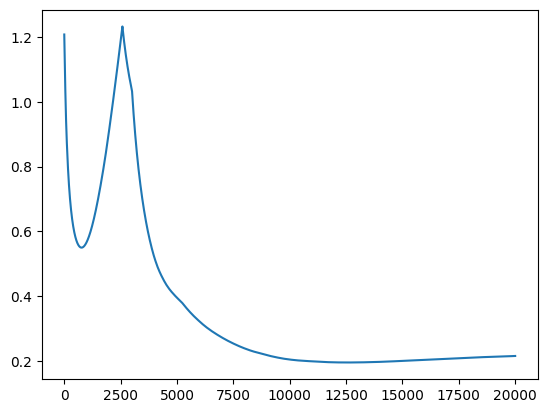

In [136]:
# No regularization -- with xavier initialization

mlr = MultiClassLogisticRegression(nclasses=3, lr=1e-2, niter=20000, lambda_reg=0.)
loss = mlr.fit(X_train, Y_train, init_wt='xavier', verbose=False)
Ypred = mlr.predict(X_test, Y_test)
plt.plot(loss)

print("----------- Testing.... ----------")
acc = np.sum(Ypred == Y_test) / len(Y_test)
print(f"Accuracy: {np.round(acc, 4)* 100}%")

**Glorot Init, Lr = 0.01, No regularization**

As we can see, Both xavier and glorot give about the same performance

----------- Testing.... ----------
Accuracy: 93.33%


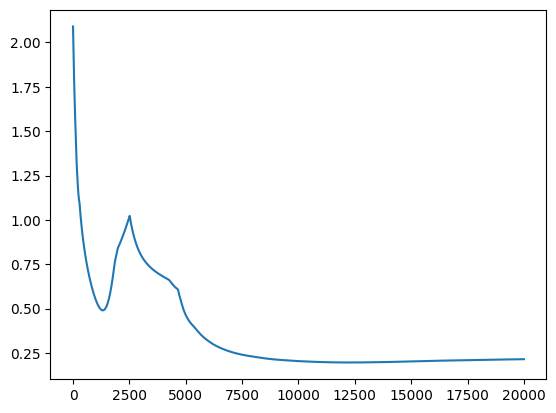

In [137]:
# No regularization -- with glorot initialization

mlr = MultiClassLogisticRegression(nclasses=3, lr=1e-2, niter=20000, lambda_reg=0.)
loss = mlr.fit(X_train, Y_train, init_wt='glorot', verbose=False)
Ypred = mlr.predict(X_test, Y_test)
plt.plot(loss)

print("----------- Testing.... ----------")
acc = np.sum(Ypred == Y_test) / len(Y_test)
print(f"Accuracy: {np.round(acc, 4)* 100}%")

**If we reduce learning rate, the curve becomes smoother, but the learning decreases**

----------- Testing.... ----------
Accuracy: 70.0%


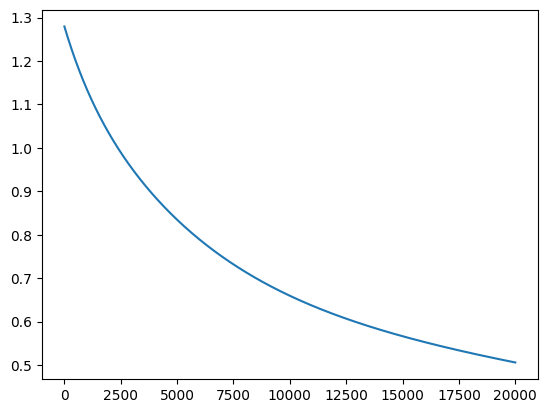

In [122]:
# No regularization -- with glorot initialization

mlr = MultiClassLogisticRegression(nclasses=3, lr=1e-3, niter=20000, lambda_reg=0.)
loss = mlr.fit(X_train, Y_train, init_wt='glorot', verbose=False)
Ypred = mlr.predict(X_test, Y_test)
plt.plot(loss)

print("----------- Testing.... ----------")
acc = np.sum(Ypred == Y_test) / len(Y_test)
print(f"Accuracy: {np.round(acc, 4)* 100}%")

***

# 6. More questions <a class="anchor" id="5"></a>



### **Q: What are some limitations of logistic regression?** <a class="anchor" id="q9"></a>

* Non-linear relationships: <br>
If the relationship is highly non-linear, logistic regression may not capture it effectively. Some non-linearity can be modeled.

* Non-linear decision boundaries: <br>
Logistic regression assumes linear decision boundaries between classes. If the classes are not linearly separable like in the image below where we see there's an overlap in 1-D data or if the decision boundaries are highly complex, we need some other model like Decision trees, Neural nets etc.

<img src="../../assets/1d_overlapdata.jpg" width=400> <img src="../../assets/unseparable_data.png" width=400>

* Complex feature interactions: <br>
Logistic regression assumes that the effect of each predictor on the target variable is independent of other predictors. But if the features are highly correlated, Logistic regression may have problems.

* High dimensional features: <br>
If the number of features in the dataset are high, Logistic regression fails.

* Categorical features: <br>
Logistic regression assumes features are numerical. It cannot directly handle categorical features like one-hot encodings. 

* Structured/sequence data :<br> 
Cannot naturally handle sequence, structured data like graph, text or genomic data. Requires embedding into fixed features. Can be used with other modifications.

### **Q: What are some assumptions we make when we use Logistic regression?** <a class="anchor" id="q10"></a>

* Linear relationship: <br>
There is a linear relationship between the logits and the predictor variables.

* Non correlated inpute features : <br>
The predictor variables are not too highly correlated with each other. Multicollinearity can cause coefficient estimates to swing wildly.

* No significant outliers: <br>
There are no significant outlier data points that can skew the fitted model. LR will be influenced by the outliers.

* Large sample size: <br> 
Logistic regression requires a large sample size, generally at least 10 cases per predictor variable in the model.

* Independent errors: <br> 
Derivative of non correlated input features. The errors or residuals of the model should be uncorrelated and independent.

* Non-zero variance: <br>
The predictor variables show some variation and are not constants or nearly constant. That's why its a good idea to do preprocessing and remove such features.



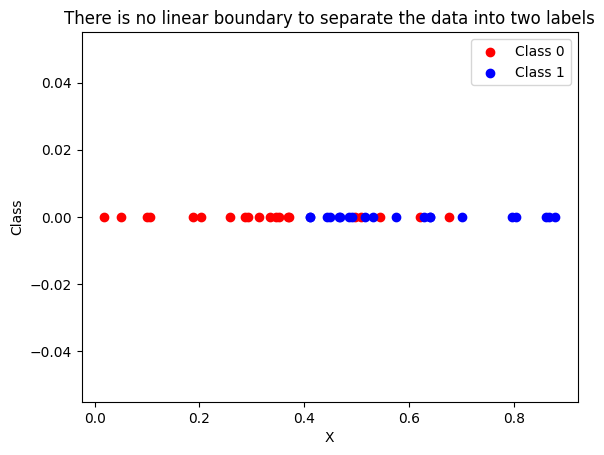

In [156]:
import matplotlib.pyplot as plt

# Generate example data
class_0_data = np.random.uniform(0, .7, (20,))
class_1_data = np.random.uniform(0.4, 1, (20,))

# Plot the data
plt.scatter(class_0_data, [0] * len(class_0_data), color='red', label='Class 0')
plt.scatter(class_1_data, [0] * len(class_1_data), color='blue', label='Class 1')

# Set plot properties
plt.xlabel('X')
plt.ylabel('Class')
plt.title('There is no linear boundary to separate the data into two labels')
plt.legend()

# Display the plot
plt.show()
